In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AlbertModel, AlbertTokenizer, TFAlbertForSequenceClassification, TFAutoModel, AlbertConfig
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_train.csv")['review']
y_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_train.csv")['sentiment']

X_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_val.csv")['review'].reset_index(drop=True)
y_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_val.csv")['sentiment'].reset_index(drop=True)

X_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_test.csv")['review'].reset_index(drop=True)
y_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_test.csv")['sentiment'].reset_index(drop=True)

X_train = X_train.astype(str).dropna()
X_val = X_val.astype(str).dropna()
X_test = X_test.astype(str).dropna()

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

X_train_list = X_train.values.tolist()
X_val_list = X_val.values.tolist()
X_test_list = X_test.values.tolist()

X_train_tokens = tokenizer.batch_encode_plus(
    X_train_list,
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_val_tokens = tokenizer.batch_encode_plus(
    X_val_list,
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_test_tokens = tokenizer.batch_encode_plus(
    X_test_list,
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_train_pad = tf.constant(X_train_tokens['input_ids'])
X_train_mask = tf.constant(X_train_tokens['attention_mask'])

X_val_pad = tf.constant(X_val_tokens['input_ids'])
X_val_mask = tf.constant(X_val_tokens['attention_mask'])

X_test_pad = tf.constant(X_test_tokens['input_ids'])
X_test_mask = tf.constant(X_test_tokens['attention_mask'])

#ALBERT - BiLSTM

In [ ]:
class CustomAlbertModel(tf.keras.Model):
    def __init__(self, num_encoded_layers, **kwargs):
        super(CustomAlbertModel, self).__init__(**kwargs)
        self.albert_model = TFAutoModel.from_pretrained("albert-base-v2")
        self.num_encoded_layers = num_encoded_layers

    def call(self, inputs, **kwargs):
        outputs = self.albert_model(inputs, **kwargs)[0]  # Use the first output
        albert_hidden_states = outputs[:, 0:self.num_encoded_layers, :]
        return albert_hidden_states

num_encoded_layers = 4
albert_model = CustomAlbertModel(num_encoded_layers)
for layer in albert_model.layers:
    layer.trainable = False

inputs = tf.keras.layers.Input(shape=(250,), dtype=tf.int32, name="input_word_ids")
mask = tf.keras.layers.Input(shape=(250,), dtype=tf.int32, name="input_mask")
albert_hidden_states = albert_model({"input_ids": inputs, "attention_mask": mask})
lstm_output = tf.keras.layers.Dropout(0.3)(albert_hidden_states)
lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(lstm_output)
lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)
lstm_output = tf.keras.layers.Dense(128, activation='relu')(lstm_output)
outputs = tf.keras.layers.Dense(3, activation='softmax')(lstm_output[:, -1, :])
model = tf.keras.models.Model(inputs=[inputs, mask], outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,  # Assuming you have integer labels
    validation_data=([X_val_pad, X_val_mask], y_val),  # Assuming you have integer labels
    batch_size=200,
    epochs=200,
    verbose=1,
    callbacks=[early_stopping_callback]  # Add early stopping callback here
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/200
686/686 [==============================] - 327s 452ms/step - loss: 0.7190 - accuracy: 0.7115 - val_loss: 0.6188 - val_accuracy: 0.7569
Epoch 2/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6493 - accuracy: 0.7453 - val_loss: 0.6189 - val_accuracy: 0.7629
Epoch 3/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6323 - accuracy: 0.7520 - val_loss: 0.5906 - val_accuracy: 0.7678
Epoch 4/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6211 - accuracy: 0.7572 - val_loss: 0.5776 - val_accuracy: 0.7745
Epoch 5/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6149 - accuracy: 0.7590 - val_loss: 0.5768 - val_accuracy: 0.7765
Epoch 6/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6077 - accuracy: 0.7614 - val_loss: 0.5862 - val_accuracy: 0.7745
Epoch 7/200
686/686 [==============================] - 306s 446ms/step - loss: 0.6001 - accuracy: 0.7656 - val_loss: 0

#Load the trained model from above

In [ ]:
y_pred = np.argmax(model.predict([X_test_pad, X_test_mask]), axis=1)
target_names = ["Class 0", "Class 1", "Class 2"]
print(classification_report(y_test, y_pred, target_names=target_names))

f1 = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("weighted F1 score:", f1)
print("micro F1 score:", f1_micro)

1681/1681 [==============================] - 132s 77ms/step
              precision    recall  f1-score   support

     Class 0       0.74      0.68      0.71     13497
     Class 1       0.56      0.06      0.11      4829
     Class 2       0.82      0.94      0.88     35440

    accuracy                           0.80     53766
   macro avg       0.71      0.56      0.57     53766
weighted avg       0.78      0.80      0.77     53766

weighted F1 score: 0.7654879881394128
micro F1 score: 0.7973998437674367


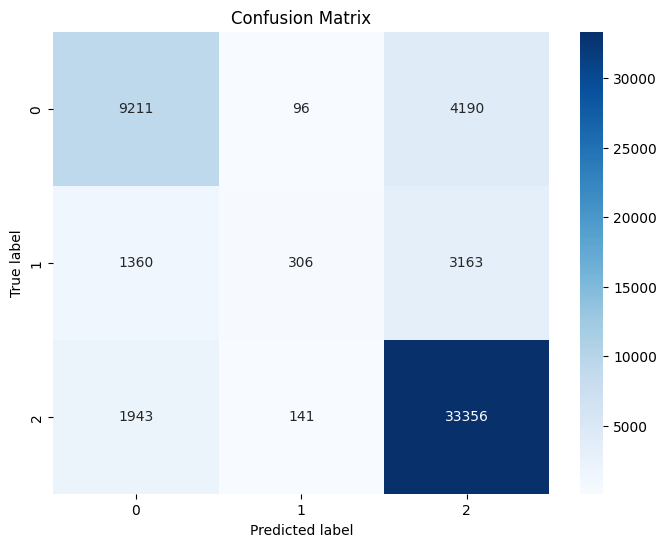

KeyError: ignored

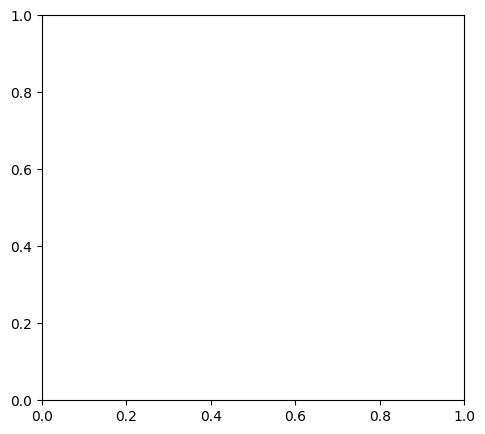

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#WITH ADAPTOR MODULE IMPLEMENTATION

In [ ]:
class Adaptor(tf.keras.layers.Layer):
    def __init__(self, hidden_size, adaptor_size, **kwargs):
        super(Adaptor, self).__init__(**kwargs)
        self.dense_down = tf.keras.layers.Dense(adaptor_size, activation=None)
        self.dense_up = tf.keras.layers.Dense(hidden_size, activation=None)
        self.activation = tf.keras.layers.Activation('relu')

    def call(self, inputs, **kwargs):
        x = self.dense_down(inputs)
        x = self.activation(x)
        x = self.dense_up(x)
        return x

class CustomAlbertModelWithAdaptor(tf.keras.Model):
    def __init__(self, num_encoded_layers, adaptor_size=256, **kwargs):
        super(CustomAlbertModelWithAdaptor, self).__init__(**kwargs)
        self.albert_model = TFAutoModel.from_pretrained("albert-base-v2")
        self.num_encoded_layers = num_encoded_layers
        self.adaptor_layers = [Adaptor(768, adaptor_size) for _ in range(num_encoded_layers)]

    def call(self, inputs, **kwargs):
        outputs = self.albert_model(inputs, **kwargs)[0]
        albert_hidden_states = outputs[:, 0:self.num_encoded_layers, :]

        # Apply each adaptor layer to the corresponding ALBERT hidden state
        adapted_hidden_states = [adaptor(hidden_state) for adaptor, hidden_state in zip(self.adaptor_layers, tf.unstack(albert_hidden_states, axis=1))]
        adapted_hidden_states = tf.stack(adapted_hidden_states, axis=1)
        return adapted_hidden_states

num_encoded_layers = 4
albert_model_with_adaptor = CustomAlbertModelWithAdaptor(num_encoded_layers)

for layer in albert_model_with_adaptor.layers:
    if not isinstance(layer, Adaptor):
        layer.trainable = False

inputs = tf.keras.layers.Input(shape=(250,), dtype=tf.int32, name="input_word_ids")
mask = tf.keras.layers.Input(shape=(250,), dtype=tf.int32, name="input_mask")
adapted_hidden_states = albert_model_with_adaptor({"input_ids": inputs, "attention_mask": mask})
lstm_output = tf.keras.layers.Dropout(0.3)(adapted_hidden_states)
lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(250, return_sequences=True))(lstm_output)
lstm_output = tf.keras.layers.Dropout(0.3)(lstm_output)
lstm_output = tf.keras.layers.Dense(128, activation='relu')(lstm_output)
outputs = tf.keras.layers.Dense(3, activation='softmax')(lstm_output[:, -1, :])
model = tf.keras.models.Model(inputs=[inputs, mask], outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = '/content/drive/MyDrive/Thesis/ALBERT-BiLSTM/General ALBERT Checkpoint/final_adaptor_AL-model_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_freq='epoch', save_weights_only=True)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    validation_data=([X_val_pad, X_val_mask], y_val),
    batch_size=200,
    epochs=200,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/200
686/686 [==============================] - 339s 464ms/step - loss: 0.6461 - accuracy: 0.7485 - val_loss: 0.6010 - val_accuracy: 0.7636
Epoch 2/200
686/686 [==============================] - 314s 457ms/step - loss: 0.5684 - accuracy: 0.7817 - val_loss: 0.5714 - val_accuracy: 0.7795
Epoch 3/200
686/686 [==============================] - 313s 457ms/step - loss: 0.5450 - accuracy: 0.7904 - val_loss: 0.5701 - val_accuracy: 0.7827
Epoch 4/200
686/686 [==============================] - 314s 457ms/step - loss: 0.5239 - accuracy: 0.7987 - val_loss: 0.5578 - val_accuracy: 0.7782
Epoch 5/200
686/686 [==============================] - 314s 457ms/step - loss: 0.5062 - accuracy: 0.8037 - val_loss: 0.5433 - val_accuracy: 0.7913
Epoch 6/200
686/686 [==============================] - 314s 457ms/step - loss: 0.4853 - accuracy: 0.8125 - val_loss: 0.5578 - val_accuracy: 0.7866
Epoch 7/200
686/686 [==============================] - 314s 457ms/step - loss: 0.4692 - accuracy: 0.8196 - val_loss: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Get the model predictions on the test set
y_pred = np.argmax(model.predict([X_test_pad, X_test_mask]), axis=1)

# Print classification report
target_names = ["Class 0", "Class 1", "Class 2"]
print(classification_report(y_test, y_pred, target_names=target_names))

# Print F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("weighted F1 score:", f1)
print("micro F1 score:", f1_micro)


1681/1681 [==============================] - 136s 78ms/step
              precision    recall  f1-score   support

     Class 0       0.70      0.78      0.74     13497
     Class 1       0.46      0.17      0.25      4829
     Class 2       0.87      0.91      0.89     35440

    accuracy                           0.81     53766
   macro avg       0.68      0.62      0.62     53766
weighted avg       0.79      0.81      0.79     53766

weighted F1 score: 0.7916690970642966
micro F1 score: 0.8076293568426142


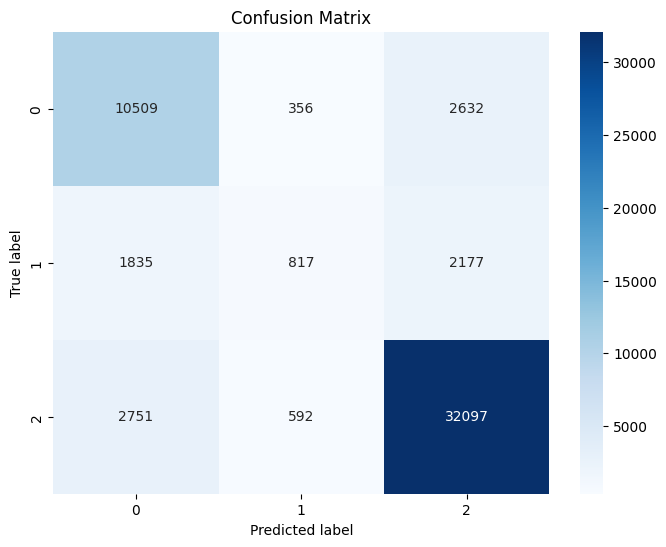

In [ ]:
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()